In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, col

import matplotlib.pyplot as plt

In [8]:
# Build the SparkSession
spark = SparkSession.builder \
   .master("local") \
   .appName("DDAM Project") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()
   
sc = spark.sparkContext

## Import

In [9]:
df_boxscore = spark.read.csv("data/boxscore_clean/part-00000-9aabd889-393c-4f37-87d7-b56657fa2ef0-c000.csv", header=True, inferSchema=True)

In [10]:
print(df_boxscore.count())

539171


In [11]:
# Renaming
df_boxscore = df_boxscore.withColumnRenamed("pos_clean", "Position")

In [12]:
df_boxscore.printSchema()

root
 |-- playerName: string (nullable = true)
 |-- game_id: integer (nullable = true)
 |-- teamName: string (nullable = true)
 |-- FG: integer (nullable = true)
 |-- FGA: integer (nullable = true)
 |-- 3P: integer (nullable = true)
 |-- 3PA: integer (nullable = true)
 |-- FT: integer (nullable = true)
 |-- FTA: integer (nullable = true)
 |-- ORB: integer (nullable = true)
 |-- DRB: integer (nullable = true)
 |-- TRB: integer (nullable = true)
 |-- AST: integer (nullable = true)
 |-- STL: integer (nullable = true)
 |-- BLK: integer (nullable = true)
 |-- TOV: integer (nullable = true)
 |-- PF: integer (nullable = true)
 |-- PTS: integer (nullable = true)
 |-- +/-: integer (nullable = true)
 |-- isStarter: integer (nullable = true)
 |-- seasonStartYear: integer (nullable = true)
 |-- isRegular: integer (nullable = true)
 |-- Ht: string (nullable = true)
 |-- Wt: double (nullable = true)
 |-- feet: double (nullable = true)
 |-- inches: string (nullable = true)
 |-- MP_seconds: integer (n

## Position one-hot-enconding

In [13]:
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="Position", outputCol="PosNum", handleInvalid="skip")

df_boxscore = indexer.fit(df_boxscore).transform(df_boxscore)

In [14]:
from pyspark.ml.feature import OneHotEncoder
onehotencoder_embarked_vector = OneHotEncoder(inputCol="PosNum", outputCol="PosVec")
df_boxscore = onehotencoder_embarked_vector.fit(df_boxscore).transform(df_boxscore)
df_boxscore.show()

23/12/11 11:54:51 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------------+-------+--------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+----+-----+------------------+------+----------+--------+-------------------+-------------------+-------------------+------+-------------+
|        playerName|game_id|            teamName| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|seasonStartYear|isRegular|  Ht|   Wt|              feet|inches|MP_seconds|Position|                TSP|                EFG|           TO_ratio|PosNum|       PosVec|
+------------------+-------+--------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+----+-----+------------------+------+----------+--------+-------------------+-------------------+-------------------+------+-------------+
|Corliss Williamson|      1|    Sacramento Kings|  7| 11|  0|  0|  0|  0|  1|  3|  4|  4|  1|  1|  4|  5| 14| -2|        1|           19

In [15]:
column2drop = ('playerName', 'game_id', 'teamName', 'seasonStartYear', 'Ht', 'Pos', 'Position', 'Wt', 'feet', 'inches')
df_boxscore = df_boxscore.drop(*column2drop)

In [16]:
# removing correlated features
too_correlated = ('FG', 'FT', 'TRB', 'TSP')
df_boxscore = df_boxscore.drop(*too_correlated)

In [17]:
df_boxscore.printSchema()

root
 |-- FGA: integer (nullable = true)
 |-- 3P: integer (nullable = true)
 |-- 3PA: integer (nullable = true)
 |-- FTA: integer (nullable = true)
 |-- ORB: integer (nullable = true)
 |-- DRB: integer (nullable = true)
 |-- AST: integer (nullable = true)
 |-- STL: integer (nullable = true)
 |-- BLK: integer (nullable = true)
 |-- TOV: integer (nullable = true)
 |-- PF: integer (nullable = true)
 |-- PTS: integer (nullable = true)
 |-- +/-: integer (nullable = true)
 |-- isStarter: integer (nullable = true)
 |-- isRegular: integer (nullable = true)
 |-- MP_seconds: integer (nullable = true)
 |-- EFG: double (nullable = true)
 |-- TO_ratio: double (nullable = true)
 |-- PosNum: double (nullable = false)
 |-- PosVec: vector (nullable = true)



## Data understanding

In [18]:
# Are data balanced?
categorical_columns = ['PosNum']

for column in categorical_columns:
    distinct_values = df_boxscore.groupBy(column).count().collect()
    print(f"Distinct values and frequencies in {column}:")
    for row in distinct_values:
        value = row[column]
        frequency = row["count"]
        print(f"{value}: {frequency}")
    print()

Distinct values and frequencies in PosNum:
0.0: 232742
1.0: 224245
2.0: 82184



## Data preparation

In [19]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [20]:
num_col = [item[0] for item in df_boxscore.dtypes if not item[1].startswith('string')]
num_col.remove("PosNum")
num_col.remove("PosVec")
print(num_col)

['FGA', '3P', '3PA', 'FTA', 'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', '+/-', 'isStarter', 'isRegular', 'MP_seconds', 'EFG', 'TO_ratio']


In [21]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

# Selezionare tutte le colonne
selected_columns = num_col

# Creare un VectorAssembler
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")

# Applicare l'assemblatore
output_dataset = assembler.transform(df_boxscore)

# Creare uno scaler per normalizzare le features
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")

# Applicare lo scaler
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
output_dataset.show(5)

+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------+----------+-------------------+-------------------+------+-------------+--------------------+--------------------+
|FGA| 3P|3PA|FTA|ORB|DRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|isRegular|MP_seconds|                EFG|           TO_ratio|PosNum|       PosVec|            features|     features_scaled|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------+----------+-------------------+-------------------+------+-------------+--------------------+--------------------+
| 11|  0|  0|  0|  1|  3|  4|  1|  1|  4|  5| 14| -2|        1|        1|      2240| 0.6363636363636364|0.21052631578947367|   1.0|(2,[1],[1.0])|[11.0,0.0,0.0,0.0...|[0.25,0.0,0.0,0.0...|
|  4|  0|  0|  4|  2|  5|  3|  1|  0|  4|  3|  1|-12|        1|        1|      1894|                0.0|0.31347962382445144|   2.0|    (2,[],[])|[4.0,0.0,0.0,4.0,...|[0.09090909090909...|
| 13|  1|  2|  2|  0|  2|  5|  1|  1|  2|  2| 17| -7|       

In [22]:
classificationData = output_dataset.select("features_scaled", "PosNum")

classificationData.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|features_scaled                                                                                                                                                                                                                                                                          |PosNum|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|[0.25,0.0,0.0,0.0,0.05555555555555555,0.13043478260869565,0.16,0.1,0.07692307692307693,0.3333333333333333,0.7142857142857142,0

In [23]:
(trainingData, testData) = classificationData.randomSplit([0.7, 0.3],seed=1)

In [24]:
# Validation split
(trainingData, valData) = trainingData.randomSplit([0.8, 0.2],seed=1)

In [25]:
trainingData.show(100, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|features_scaled                                                                                                                                                                                                                          |PosNum|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|(18,[0,1,2,3,4,5,11,12,15,16],[0.06818181818181818,0.07142857142857142,0.041666666666666664,0.05128205128205128,0.05555555555555555,0.043478260869565216,0.09999999999999999,0.5614035087719298,0.02539763981528989,0.7777777777777778]) |0.0   |
|(18,[0,1,2,3,4,5,11,12,15,1

## Decision Tree

In [26]:
def plot_importance(importance):
    keys = importance.keys()
    values = importance.values()

    # Plot the dictionary
    plt.figure(figsize=(17,5))
    plt.bar(keys, values)
    plt.xlabel("Keys")
    plt.ylabel("Values")
    plt.title("Dictionary Plot")
    plt.show()

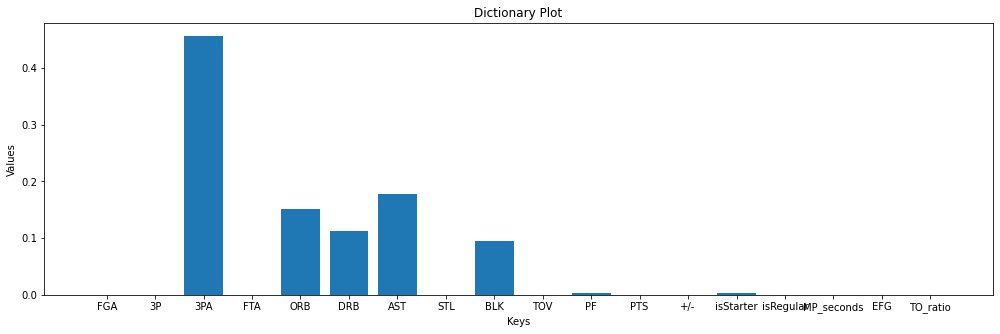

With parameters {'maxDepth': 7, 'maxBins': 32, 'impurity': 'entropy'}


Validation accuracy = 0.6367104705383637


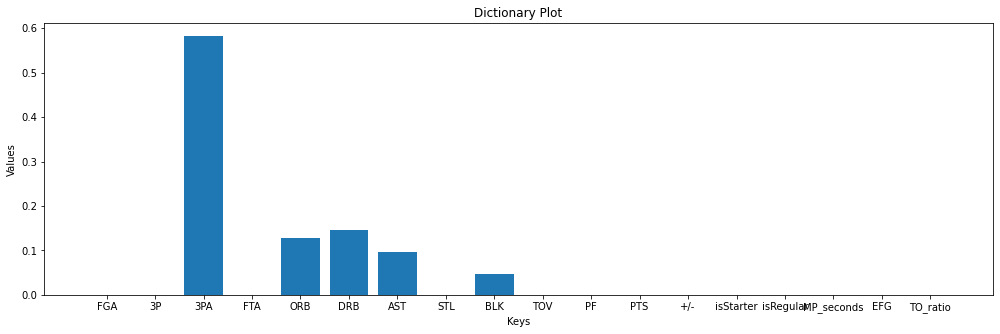

With parameters {'maxDepth': 3, 'maxBins': 32, 'impurity': 'gini'}


Validation accuracy = 0.5965583933870284


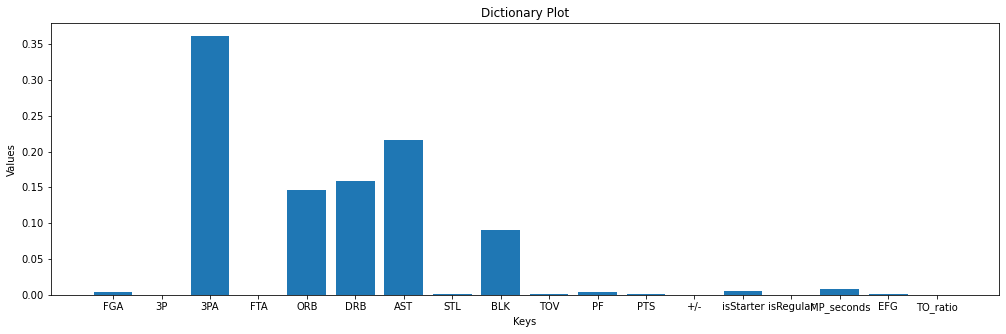

With parameters {'maxDepth': 9, 'maxBins': 32, 'impurity': 'gini'}


Validation accuracy = 0.6430293556591776


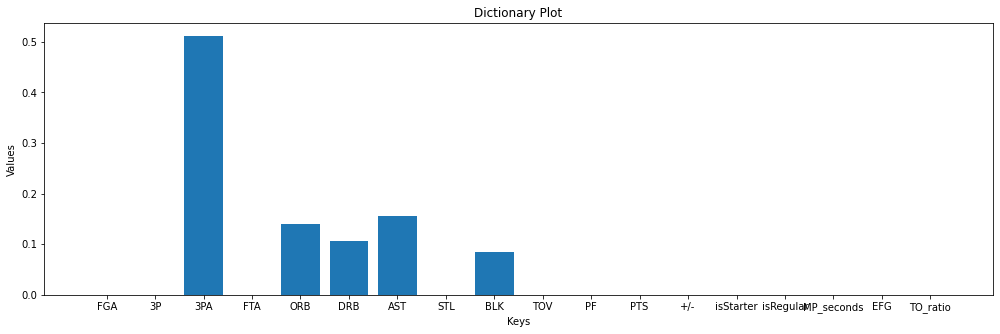

With parameters {'maxDepth': 5, 'maxBins': 64, 'impurity': 'entropy'}


Validation accuracy = 0.6237680161085205


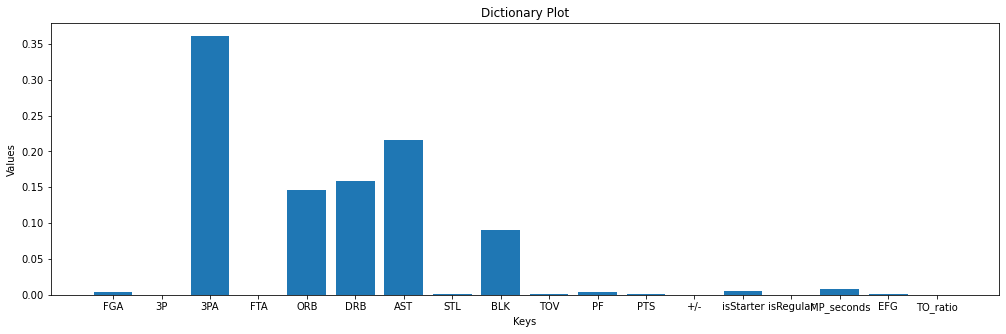

With parameters {'maxDepth': 9, 'maxBins': 64, 'impurity': 'gini'}


Validation accuracy = 0.6429498728274693


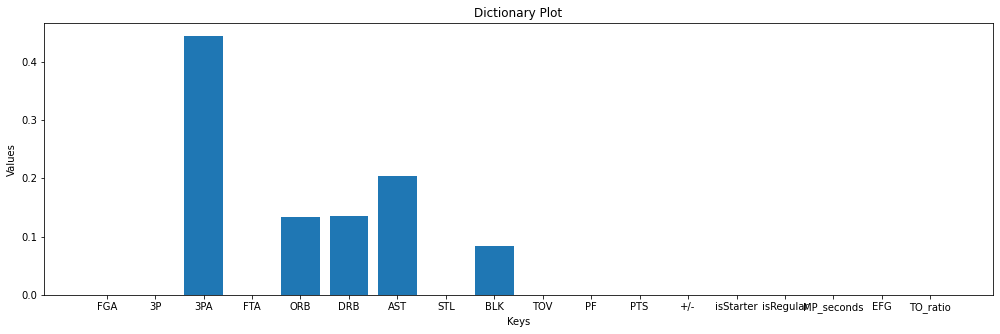

With parameters {'maxDepth': 5, 'maxBins': 32, 'impurity': 'gini'}


Validation accuracy = 0.6244966087325138


In [27]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
import random
import itertools

# random search
hyperparameters = {
    'maxDepth': [3, 5, 7, 9],
    'maxBins' : [16, 32, 64],
    'impurity' : ['gini', 'entropy']
}

number_of_combinations = 6
random_combinations = random.sample(list(itertools.product(*hyperparameters.values())), number_of_combinations)

for combo in random_combinations:
    param_dict = dict(zip(hyperparameters.keys(), combo))

    dt = DecisionTreeClassifier(labelCol="PosNum", featuresCol="features_scaled", impurity=param_dict['impurity'], maxDepth=param_dict['maxDepth'], maxBins=param_dict['maxBins'])

    dt = dt.fit(trainingData)

    importance = {}
    featureImportances = list(dt.featureImportances)

    for i,e in enumerate(featureImportances):
        importance[num_col[i]] = e
    
    plot_importance(importance)

    # Make predictions
    predictions = dt.transform(valData)

    # Select (prediction, true label) and compute test error
    evaluator = MulticlassClassificationEvaluator(labelCol="PosNum"
                                                , predictionCol="prediction"
                                                , metricName="accuracy")

    print('With parameters', param_dict)
    accuracy = evaluator.evaluate(predictions)
    print('Validation accuracy =', accuracy)

In [29]:
dt = DecisionTreeClassifier(labelCol="PosNum", featuresCol="features_scaled", impurity='entropy', maxDepth=9, maxBins=64)

dt = dt.fit(trainingData)

In [30]:
dt.featureImportances

SparseVector(18, {0: 0.0033, 1: 0.0001, 2: 0.419, 3: 0.0003, 4: 0.1502, 5: 0.1363, 6: 0.1837, 7: 0.0005, 8: 0.0919, 9: 0.0002, 10: 0.0046, 11: 0.0003, 12: 0.0002, 13: 0.0042, 15: 0.0045, 16: 0.0007, 17: 0.0002})

In [31]:
importance = {}
featureImportances = list(dt.featureImportances)

for i,e in enumerate(featureImportances):
    importance[num_col[i]] = e

importance

{'FGA': 0.003335124939120823,
 '3P': 6.29903817498968e-05,
 '3PA': 0.41896335953839514,
 'FTA': 0.00029011097003425767,
 'ORB': 0.15018670039940937,
 'DRB': 0.13627375017886725,
 'AST': 0.18369958184225754,
 'STL': 0.0005175905514565712,
 'BLK': 0.09187494380009671,
 'TOV': 0.0002232749044343181,
 'PF': 0.004612412356096733,
 'PTS': 0.00027532132552660364,
 '+/-': 0.00016610811790196544,
 'isStarter': 0.004229797424243183,
 'isRegular': 0.0,
 'MP_seconds': 0.004459411441688573,
 'EFG': 0.0006699860796762584,
 'TO_ratio': 0.0001595357490448041}

In [32]:
# Make predictions
predictions = dt.transform(valData)

predictions.show(10)

+--------------------+------+--------------------+--------------------+----------+
|     features_scaled|PosNum|       rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+----------+
|(18,[0,1,2,3,4,7,...|   0.0|[7882.0,4714.0,31...|[0.61067637715968...|       0.0|
|(18,[0,1,2,3,4,11...|   1.0|[7882.0,4714.0,31...|[0.61067637715968...|       0.0|
|(18,[0,1,2,3,4,11...|   0.0|[7882.0,4714.0,31...|[0.61067637715968...|       0.0|
|(18,[0,1,2,3,4,11...|   1.0|[7882.0,4714.0,31...|[0.61067637715968...|       0.0|
|(18,[0,1,2,3,4,11...|   0.0|[7882.0,4714.0,31...|[0.61067637715968...|       0.0|
|(18,[0,1,2,3,4,11...|   0.0|[7882.0,4714.0,31...|[0.61067637715968...|       0.0|
|(18,[0,1,2,3,4,11...|   0.0|[7882.0,4714.0,31...|[0.61067637715968...|       0.0|
|(18,[0,1,2,3,4,11...|   0.0|[7882.0,4714.0,31...|[0.61067637715968...|       0.0|
|(18,[0,1,2,3,5,6,...|   0.0|[12655.0,3711.0,1...|[0.76585572500605...|       0.0|
|(18

In [33]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="PosNum"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print('Validation accuracy =', accuracy)
print("Validation Error = %g" % (1.0 - accuracy))

predictions_test = dt.transform(testData)
accuracy_test = evaluator.evaluate(predictions_test)
print('Test accuracy =', accuracy_test)
print("Test Error = %g" % (1.0 - accuracy_test))

Validation accuracy = 0.642870389995761
Validation Error = 0.35713


Test accuracy = 0.6414418420792568
Test Error = 0.358558


Using 'Ht', the decision tree obtains nearly 89% of accuracy. Without it, we reach 65% accuracy on the validation set.

## Gradient-Boosted Tree

In [34]:
# Save the model for future use
#model.save("path_to_save_model")

# Load the saved model
#loaded_model = GBTClassifier.load("path_to_saved_model")

## Multilayer Perceptron Classifier

In [35]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

layers = [18, 40, 20, 3]  # Define the layers of the neural network
mlp = MultilayerPerceptronClassifier(labelCol="PosNum", featuresCol="features_scaled", layers=layers, seed=1234)

model = mlp.fit(trainingData)

predictions = model.transform(valData)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="PosNum", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Validation accuracy:", accuracy)

23/12/11 12:03:30 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/12/11 12:03:30 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Validation accuracy: 0.6547265790589233


In [36]:
predictions.show(20)

+--------------------+------+--------------------+--------------------+----------+
|     features_scaled|PosNum|       rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+----------+
|(18,[0,1,2,3,4,7,...|   0.0|[0.62532311456895...|[0.54701273892892...|       0.0|
|(18,[0,1,2,3,4,11...|   1.0|[0.23190297524152...|[0.43561724904586...|       1.0|
|(18,[0,1,2,3,4,11...|   0.0|[0.00884651962103...|[0.37949287576483...|       1.0|
|(18,[0,1,2,3,4,11...|   1.0|[-0.2787187647146...|[0.30504847607504...|       1.0|
|(18,[0,1,2,3,4,11...|   0.0|[0.09240277351151...|[0.40182649449818...|       1.0|
|(18,[0,1,2,3,4,11...|   0.0|[1.16822185414670...|[0.67104522815508...|       0.0|
|(18,[0,1,2,3,4,11...|   0.0|[1.43868196034134...|[0.71201740049923...|       0.0|
|(18,[0,1,2,3,4,11...|   0.0|[0.90514895820658...|[0.61167883673426...|       0.0|
|(18,[0,1,2,3,5,6,...|   0.0|[2.14930682701004...|[0.85731363663766...|       0.0|
|(18

In [37]:
model

MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_0ef9bb5db99d, numLayers=4, numClasses=3, numFeatures=18

## Random Forest

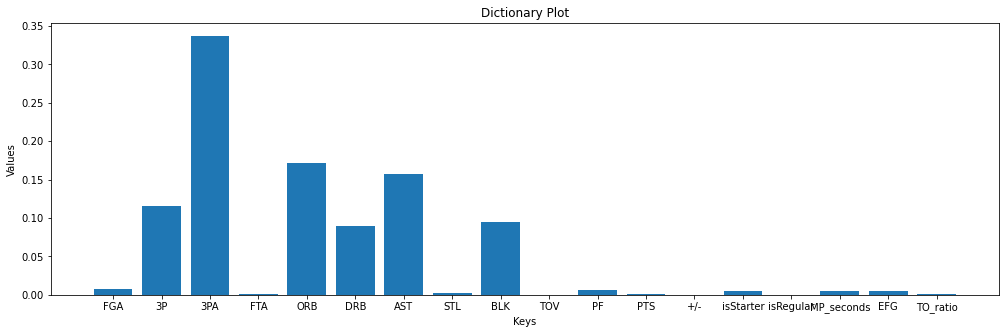

With parameters {'numTrees': 25, 'maxDepth': 6, 'maxBins': 64, 'impurity': 'entropy'}


Validation accuracy = 0.633584145824502


23/12/11 12:24:47 WARN DAGScheduler: Broadcasting large task binary with size 1104.9 KiB
23/12/11 12:24:54 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


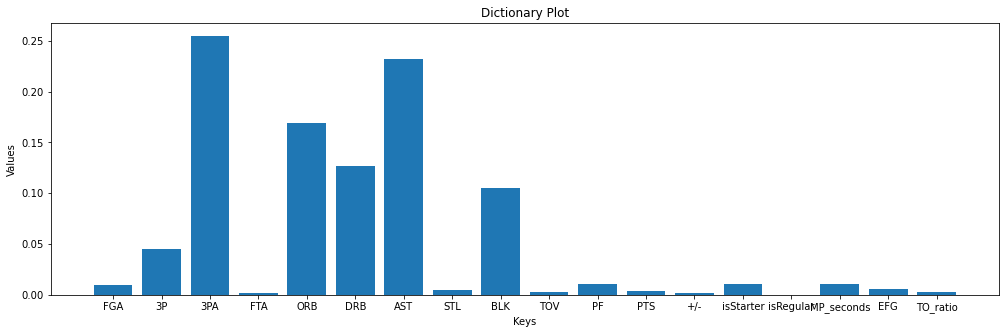

With parameters {'numTrees': 25, 'maxDepth': 9, 'maxBins': 32, 'impurity': 'gini'}


23/12/11 12:25:03 WARN DAGScheduler: Broadcasting large task binary with size 1423.0 KiB


Validation accuracy = 0.6510306273844849


23/12/11 12:26:25 WARN DAGScheduler: Broadcasting large task binary with size 1087.8 KiB
23/12/11 12:26:40 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/12/11 12:26:54 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
23/12/11 12:27:08 WARN DAGScheduler: Broadcasting large task binary with size 1184.6 KiB


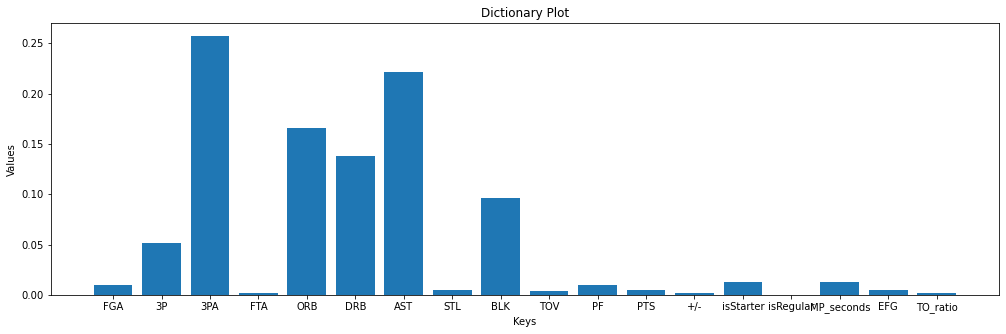

With parameters {'numTrees': 50, 'maxDepth': 9, 'maxBins': 32, 'impurity': 'gini'}


23/12/11 12:27:10 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


Validation accuracy = 0.651494277236117


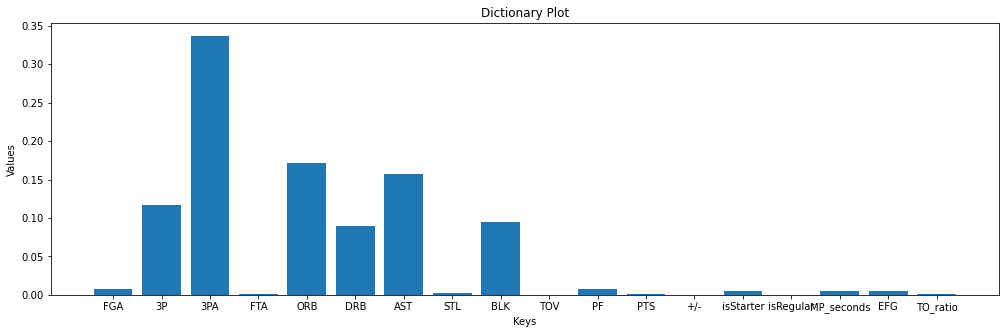

With parameters {'numTrees': 25, 'maxDepth': 6, 'maxBins': 16, 'impurity': 'entropy'}


Validation accuracy = 0.63359739296312


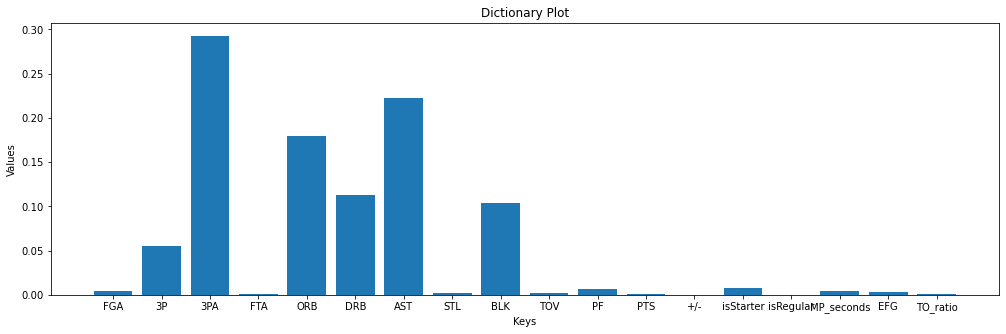

With parameters {'numTrees': 25, 'maxDepth': 6, 'maxBins': 16, 'impurity': 'gini'}


Validation accuracy = 0.6366972233997457


23/12/11 12:30:38 WARN DAGScheduler: Broadcasting large task binary with size 1086.4 KiB
23/12/11 12:30:52 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/12/11 12:31:06 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
23/12/11 12:31:23 WARN DAGScheduler: Broadcasting large task binary with size 1188.1 KiB


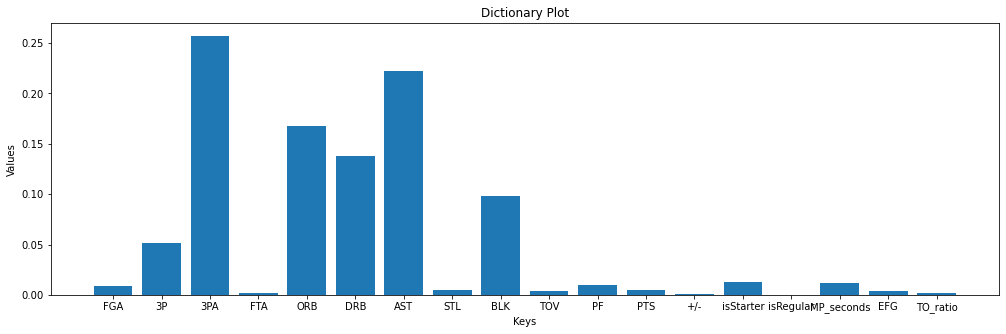

With parameters {'numTrees': 50, 'maxDepth': 9, 'maxBins': 16, 'impurity': 'gini'}


23/12/11 12:31:25 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


Validation accuracy = 0.6516664900381518


23/12/11 12:32:32 WARN DAGScheduler: Broadcasting large task binary with size 1089.2 KiB
23/12/11 12:32:42 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/12/11 12:32:53 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
23/12/11 12:33:07 WARN DAGScheduler: Broadcasting large task binary with size 1192.6 KiB


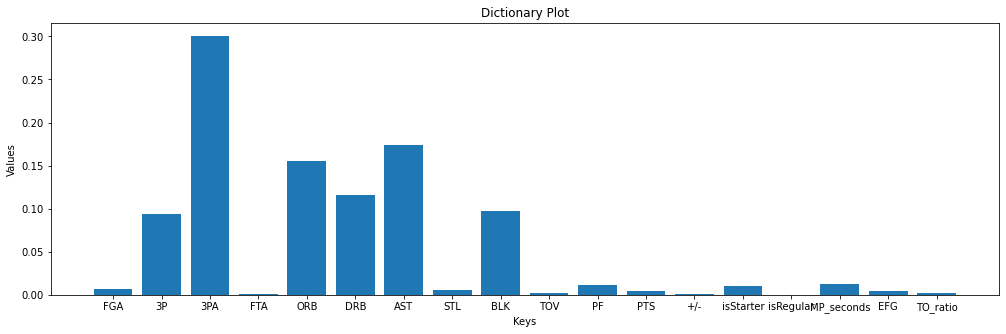

With parameters {'numTrees': 50, 'maxDepth': 9, 'maxBins': 64, 'impurity': 'entropy'}


23/12/11 12:33:09 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


Validation accuracy = 0.649229016532429


23/12/11 12:34:33 WARN DAGScheduler: Broadcasting large task binary with size 1089.0 KiB
23/12/11 12:34:51 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/12/11 12:35:05 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
23/12/11 12:35:21 WARN DAGScheduler: Broadcasting large task binary with size 1182.4 KiB


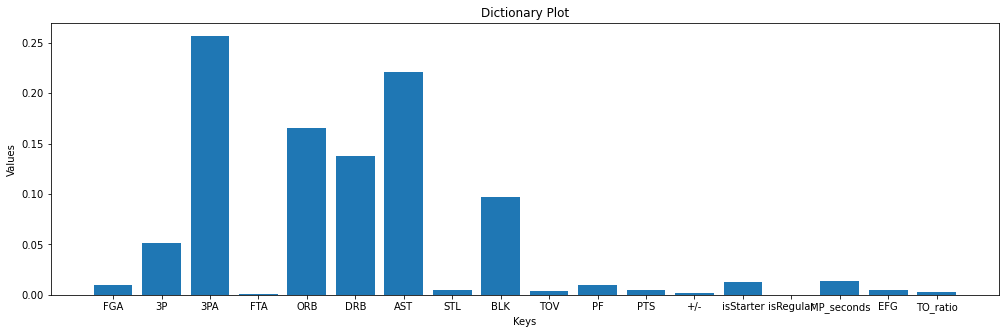

With parameters {'numTrees': 50, 'maxDepth': 9, 'maxBins': 64, 'impurity': 'gini'}


23/12/11 12:35:24 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


Validation accuracy = 0.6512955701568461


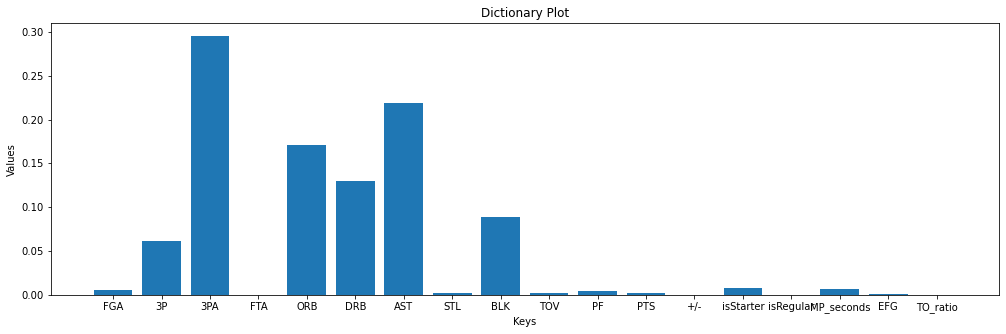

With parameters {'numTrees': 50, 'maxDepth': 6, 'maxBins': 32, 'impurity': 'gini'}


Validation accuracy = 0.6365647520135651


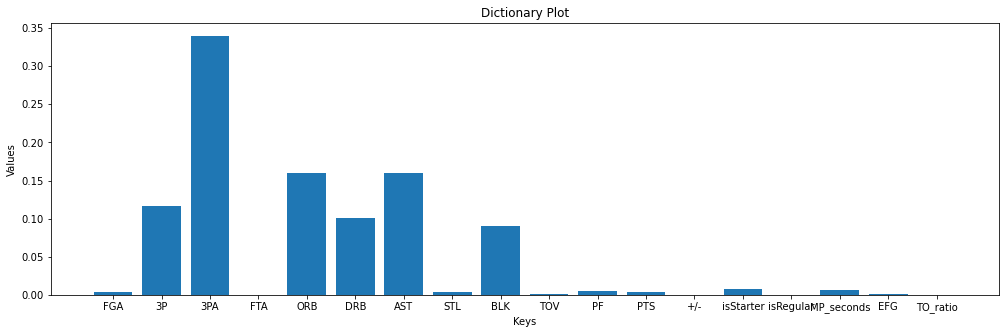

With parameters {'numTrees': 50, 'maxDepth': 6, 'maxBins': 64, 'impurity': 'entropy'}


Validation accuracy = 0.6326568461212378


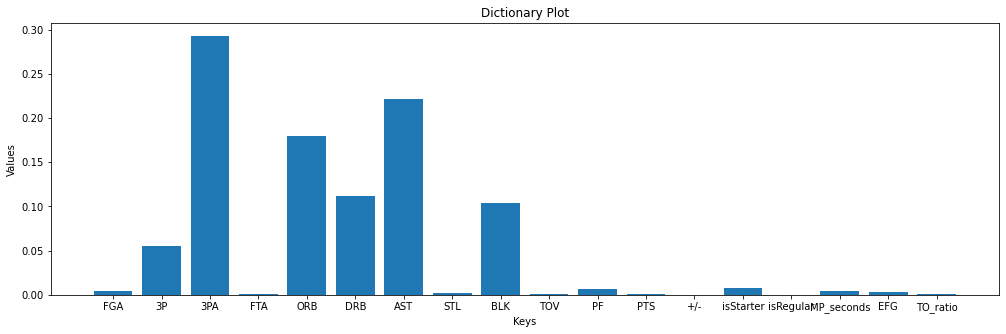

With parameters {'numTrees': 25, 'maxDepth': 6, 'maxBins': 64, 'impurity': 'gini'}


Validation accuracy = 0.6362733149639678


23/12/11 12:39:26 WARN DAGScheduler: Broadcasting large task binary with size 1102.9 KiB
23/12/11 12:39:30 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


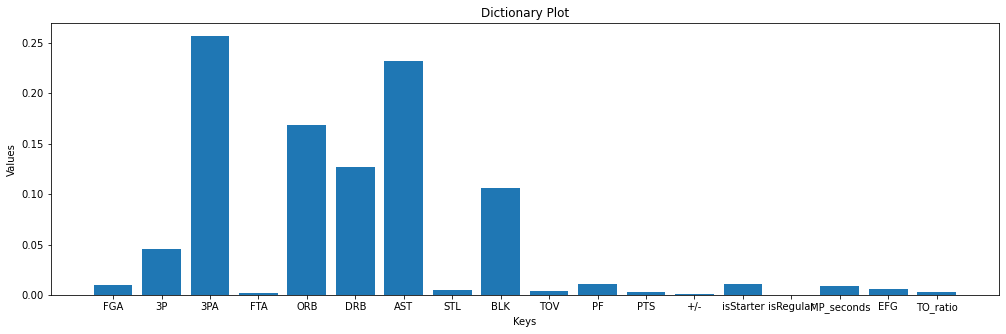

With parameters {'numTrees': 25, 'maxDepth': 9, 'maxBins': 16, 'impurity': 'gini'}


23/12/11 12:39:37 WARN DAGScheduler: Broadcasting large task binary with size 1401.5 KiB


Validation accuracy = 0.6511895930479017


In [39]:
# random search
hyperparameters = {
    'numTrees': [25, 50],
    'maxDepth': [6, 9],
    'maxBins' : [16, 32, 64],
    'impurity' : ['gini', 'entropy']
}

number_of_combinations = 12
random_combinations = random.sample(list(itertools.product(*hyperparameters.values())), number_of_combinations)

for combo in random_combinations:
    param_dict = dict(zip(hyperparameters.keys(), combo))
    
    rf = RandomForestClassifier(labelCol="PosNum", featuresCol="features_scaled", numTrees=param_dict['numTrees'], impurity=param_dict['impurity'], maxDepth=param_dict['maxDepth'], maxBins=param_dict['maxBins'])

    rf = rf.fit(trainingData)

    importance = {}
    featureImportances = list(rf.featureImportances)

    for i,e in enumerate(featureImportances):
        importance[num_col[i]] = e
    
    plot_importance(importance)

    # Make predictions
    predictions = rf.transform(valData)

    # Select (prediction, true label) and compute test error
    evaluator = MulticlassClassificationEvaluator(labelCol="PosNum"
                                                , predictionCol="prediction"
                                                , metricName="accuracy")

    print('With parameters', param_dict)
    accuracy = evaluator.evaluate(predictions)
    print('Validation accuracy =', accuracy)
    
    

In [41]:
rf = RandomForestClassifier(labelCol="PosNum", featuresCol="features_scaled", numTrees= 50, maxDepth= 9, maxBins= 16, impurity= 'gini')

rf = rf.fit(trainingData)

23/12/11 12:44:09 WARN DAGScheduler: Broadcasting large task binary with size 1086.4 KiB
23/12/11 12:44:20 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/12/11 12:44:33 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
23/12/11 12:44:51 WARN DAGScheduler: Broadcasting large task binary with size 1188.1 KiB


In [42]:
rf.featureImportances

SparseVector(18, {0: 0.0092, 1: 0.0516, 2: 0.257, 3: 0.0015, 4: 0.1672, 5: 0.1381, 6: 0.2225, 7: 0.0047, 8: 0.098, 9: 0.0039, 10: 0.0094, 11: 0.0045, 12: 0.0012, 13: 0.0128, 14: 0.0002, 15: 0.0119, 16: 0.0043, 17: 0.0022})

In [ ]:
importance = {}
featureImportances = list(rf.featureImportances)

for i,e in enumerate(featureImportances):
    importance[num_col[i]] = e

importance

{'FGA': 0.009237997544972452,
 '3P': 0.051609774403026075,
 '3PA': 0.25697149981138984,
 'FTA': 0.0014945294185306419,
 'ORB': 0.16717734526704775,
 'DRB': 0.13806838110516315,
 'AST': 0.22248069846899515,
 'STL': 0.0046589720109432835,
 'BLK': 0.09800856367816921,
 'TOV': 0.00387402289810345,
 'PF': 0.009369542376732959,
 'PTS': 0.004476833826556965,
 '+/-': 0.0011808223256914634,
 'isStarter': 0.01281010679629582,
 'isRegular': 0.00020585026255113984,
 'MP_seconds': 0.011886780962158618,
 'EFG': 0.004337094499766828,
 'TO_ratio': 0.002151184343905236}

23/12/12 15:54:48 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 33356602 ms exceeds timeout 120000 ms
23/12/12 15:54:49 WARN SparkContext: Killing executors is not supported by current scheduler.
23/12/12 15:54:51 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint